In [55]:
# Import des librairies
import numpy as np
import pandas as pd
import seaborn as sns
import re
from sklearn import decomposition
from sklearn import preprocessing

### Lecture des fichiers import CSV

In [56]:
# 1.  kcal

# Bilans Alimentaires > 
#  [Regions]  = "Pays" - "Chine-RAS de Hong-Kong" , "Chine-RAS de Macao" , "Chine, Taiwan Province" , "Chine, continentale" 
#  [Elements] = "Disponibilité alimentaire (Kcal/personne/jour)"
#  [Produits] = "Total General + (Total) " + 
#  [Années]   = 2013 
#                                  ->  dans kcal.csv  <- La "Chine" est dans le fichier kcal.csv
# options (Table,Virgule)

kcal = pd.read_csv("kcal.csv")

kcal = kcal.drop(['Domaine','Élément','Produit','Année'], 1)   # Suppression des colonnes inutiles
kcal.columns = ['Pays', 'kcal']                                # Renommage des colonnes restantes

kcal.head(3)

,Pays,kcal
0,Afghanistan,2090
1,Afrique du Sud,3022
2,Albanie,3193


In [3]:
# 2.  PIB

# Données de la sécurité alimentaire > 
#  [Regions]  = "Pays" - "Chine-RAS de Hong-Kong" , "Chine-RAS de Macao" , "Chine, Taiwan Province" , "Chine, continentale" 
#  [Elements] = "Valeur"
#  [Produits] = "PIB par habitant, ($ PPA internationaux constants de 2011) "    Unité = I$
#  [Années]   = 2013 
#                                  ->  dans pib.csv  <- La "Chine" est dans le fichier pib.csv
# options (Table,Virgule)

pib = pd.read_csv("pib.csv")

pib = pib.drop(['Domaine','Élément','Produit','Année'], 1)   # Suppression des colonnes inutiles
pib.columns = ['Pays', 'PIB']                                # Renommage des colonnes restantes

pib = pib.sort_values(by = ['PIB'], ascending=False)
pib.head(5)


#  PIB :
#  [+25000]        : Pays riches   (ex: France  -> 37350)
#  [15000;25000]   : ............  (ex: Algérie -> 13253)
#  [5000;15000]    : ............  (ex: Maroc   -> 6995)
#  [1000;5000]     : Pays pauvres  (ex: Mauritanie -> 3565)
#  [-1000]         : ............  (ex: Congo)

# PIB moyen par habitant dans le monde estimé à 10152 $

# Le Qatar n'est visible que pour les "Données de la sécurité alimentaire" mais pas dans les "Bilans Alimentaires".
# Du coup le PIB du Qatar est connu mais pas le kcal, Prtoteine, ani%, popPlus%

,Pays,PIB
135,Qatar,122637.0
98,Luxembourg,90656.4
27,Brunéi Darussalam,79070.2
155,Singapour,78896.6
90,Koweït,74084.5


In [4]:
# 3.  proteine & ani%

# Bilans Alimentaires > 
#  [Regions]  = "Pays" - "Chine-RAS de Hong-Kong" , "Chine-RAS de Macao" , "Chine, Taiwan Province" , "Chine, continentale" 
#  [Elements] = "Disponibilité de protéines en quantité (g/personne/jour)"
#  [Produits] = "Produits Animaux > (Total)" + "Total General + (Total)"
#  [Années]   = 2013 
#                                  ->  dans prot.csv  <- La "Chine" est dans le fichier prot.csv
# options (Table,Virgule)

temp = pd.read_csv("prot.csv")

# Suppression des colonnes inutiles
temp = temp.drop(['Domaine','Élément','Année'], 1)

# Réorganisation de la dataframe pour présenter les 'Valeur' en fonction du Pays
prot = temp.pivot_table(index=["Pays"], columns = ["Produit"], values=["Valeur"], aggfunc=sum)
prot = prot.reset_index()

prot.columns = prot.columns.droplevel(level=[0])   # Mis à plat du multiIndex
prot.columns = ['Pays', 'protAni', 'Proteine']     # Renommage des colonnes restantes

prot["ani%"]= (prot.protAni / prot.Proteine)*100   # Ajout de la colonne 'ani%'
prot = prot.drop(['protAni'], 1)                   # Suppression de la colonne 'protAni' après calcul de 'ani%'

prot.head(3)


,Pays,Proteine,ani%
0,Afghanistan,58.25,20.978541
1,Afrique du Sud,85.33,42.634478
2,Albanie,111.42,53.329743


In [5]:
# 4.  population

# Bilans Alimentaires > 
#   [Pays]=  "Tout sélectionner "   + 
#   [Elements]= "Population totale" + 
#   [Produits]="Population"+ [Années]= 2013 ,2012
#                                                 ->  dans pop.csv  <- La "Chine" est dans le fichier pop.csv
#  avec options (pivot,rien)

pop = pd.read_csv("pop.csv", sep=",")

# Suppression des colonnes inutiles
pop = pop.drop(['Domaine','Élément','Produit'], 1)

# Réorganisation de la dataframe pour présenter les 'Valeur' en fonction du Pays
pop = pop.pivot_table(index=["Pays"], columns = ["Année"], values=["Valeur"], aggfunc=sum)
pop = pop.reset_index()

pop.columns = pop.columns.droplevel(level=[0])   # Mis à plat du multiIndex
pop.columns = ['Pays', 'a2012', 'a2013']          # Renommage des colonnes restantes

pop["popPlus%"]= ((pop.a2013 - pop.a2012) / pop.a2012) *100   # pour avoir des %
pop = pop.drop(['a2012','a2013'], 1)                          # Suppression des colonnes inutiles après le calcul

pop = pop.sort_values(by = ['popPlus%'], ascending=False)
pop.head(5)


,Pays,popPlus%
110,Oman,9.595655
104,Niger,3.928426
75,Jordanie,3.780853
83,Liban,3.765870
80,Koweït,3.661538


In [6]:
# 5.  volaille

# Bilans Alimentaires > 
#  [Regions]  = "Monde > (Liste)" + 
#  [Elements] = 'Exportations - Quantité' , 'Importations - Quantité' , 'Production' 
#  [Produits] = "viande de volaille " + 
#  [Années]   = 2013 
#                                  -> dans volaille.csv  <- La "Chine" est dans le fichier volaille.csv
# options (Table,Virgule)

temp = pd.read_csv("volaille.csv")

# Suppression des colonnes inutiles
temp = temp.drop(['Domaine','Produit','Année'], 1)

# Réorganisation de la dataframe pour présenter les 'Valeur' en fonction du Pays
volaille = temp.pivot_table(index=["Pays"], columns = ["Élément"], values=["Valeur"], aggfunc=sum)
volaille = volaille.reset_index()

volaille.columns = volaille.columns.droplevel(level=[0])   # Mis à plat du multiIndex
volaille.columns = ['Pays', 'export', 'import', 'produc']  # Renommage des colonnes restantes

# Suprimer les lignes ou Valeur = NaN, 0.000
volaille = volaille.fillna(0)              # Remplace les NaN par des 0
#volaille = volaille[volaille.Valeur != 0]    # Ne conserve que les lignes ou 'Valeur' != 0

# Taux de Dépendance des importations (TDI) :    TDI = Import / (Produc+ Import -Export)*100
volaille['tdi'] = volaille['import'] / (volaille['produc']+ volaille['import'] -volaille['export']) * 100
volaille['tdi'] = round(volaille['tdi'],2)
# ex: tdi=20%  => indique que 80% de l'approvisionnement intérieur en volaille provient de la production intérieure.
#              => indique une dépendance à 20%

# Suppression des colonnes inutiles
volaille = volaille.drop(['export','import','produc'], 1)
volaille.head(10)


,Pays,tdi
0,Afghanistan,64.86
1,Afrique du Sud,17.97
2,Albanie,59.52
3,Algérie,1.03
4,Allemagne,50.22
5,Angola,91.94
6,Antigua-et-Barbuda,100.00
7,Arabie saoudite,62.16
8,Argentine,0.25
9,Arménie,80.00


In [7]:
# 6. continent et/ou sous-continent

# Bilans Alimentaires > 
#   [Régions]=  "amerique>(Liste) "    + 
#   [Elements]= "Population totale" + 
#   [Produits]="Population"+ [Années]= 2013
#                                                 -> dans pop.csv

# -------- AFRIQUE --------------------
afrique = pd.read_csv("afrique.csv", sep=",")
afrique = afrique.drop(['Domaine','Élément','Produit','Année','Valeur'], 1)
afrique['continent'] = 'afrique'


afrique_centrale = pd.read_csv("afrique_centrale.csv", sep=",")
afrique_centrale = afrique_centrale.drop(['Domaine','Élément','Produit','Année','Valeur'], 1)
afrique_centrale['continent'] = 'afrique_centrale'

afrique_est = pd.read_csv("afrique_est.csv", sep=",")
afrique_est = afrique_est.drop(['Domaine','Élément','Produit','Année','Valeur'], 1)
afrique_est['continent'] = 'afrique_est'

afrique_nord = pd.read_csv("afrique_nord.csv", sep=",")
afrique_nord = afrique_nord.drop(['Domaine','Élément','Produit','Année','Valeur'], 1)
afrique_nord['continent'] = 'afrique_nord'

afrique_ouest = pd.read_csv("afrique_ouest.csv", sep=",")
afrique_ouest = afrique_ouest.drop(['Domaine','Élément','Produit','Année','Valeur'], 1)
afrique_ouest['continent'] = 'afrique_ouest'

afrique_sud = pd.read_csv("afrique_sud.csv", sep=",")
afrique_sud = afrique_sud.drop(['Domaine','Élément','Produit','Année','Valeur'], 1)
afrique_sud['continent'] = 'afrique_sud'

# --------- AMERIQUE ---------------------
amerique = pd.read_csv("amerique.csv", sep=",")
amerique = amerique.drop(['Domaine','Élément','Produit','Année','Valeur'], 1)
amerique['continent'] = 'amerique'


amerique_centrale = pd.read_csv("amerique_centrale.csv", sep=",")
amerique_centrale = amerique_centrale.drop(['Domaine','Élément','Produit','Année','Valeur'], 1)
amerique_centrale['continent'] = 'amerique_centrale'

amerique_nord = pd.read_csv("amerique_nord.csv", sep=",")
amerique_nord = amerique_nord.drop(['Domaine','Élément','Produit','Année','Valeur'], 1)
amerique_nord['continent'] = 'amerique_nord'

amerique_sud = pd.read_csv("amerique_sud.csv", sep=",")
amerique_sud = amerique_sud.drop(['Domaine','Élément','Produit','Année','Valeur'], 1)
amerique_sud['continent'] = 'amerique_sud'

# --------- ASIE -----------------------
asie = pd.read_csv("asie.csv", sep=",")
asie = asie.drop(['Domaine','Élément','Produit','Année','Valeur'], 1)
asie = asie[asie.Pays != 'Chine - RAS de Hong-Kong']
asie = asie[asie.Pays != 'Chine - RAS de Macao']
asie = asie[asie.Pays != 'Chine, continentale']
asie = asie[asie.Pays != 'Chine, Taiwan Province de']
asie['continent'] = 'asie'
chine = pd.DataFrame([["Chine", "asie"]], columns = asie.columns)
asie = asie.append(chine, ignore_index=True)

asie_centrale = pd.read_csv("asie_centrale.csv", sep=",")
asie_centrale = asie_centrale.drop(['Domaine','Élément','Produit','Année','Valeur'], 1)
asie_centrale['continent'] = 'asie_centrale'

asie_est = pd.read_csv("asie_est.csv", sep=",")
asie_est = asie_est.drop(['Domaine','Élément','Produit','Année','Valeur'], 1)
asie_est = asie_est[asie_est.Pays != 'Chine - RAS de Hong-Kong']
asie_est = asie_est[asie_est.Pays != 'Chine - RAS de Macao']
asie_est = asie_est[asie_est.Pays != 'Chine, continentale']
asie_est = asie_est[asie_est.Pays != 'Chine, Taiwan Province de']
asie_est['continent'] = 'asie_est'
chine = pd.DataFrame([["Chine", "asie_est"]], columns = asie_est.columns)
asie_est = asie_est.append(chine, ignore_index=True)

asie_ouest = pd.read_csv("asie_ouest.csv", sep=",")
asie_ouest = asie_ouest.drop(['Domaine','Élément','Produit','Année','Valeur'], 1)
asie_ouest['continent'] = 'asie_ouest'

asie_sud = pd.read_csv("asie_sud.csv", sep=",")
asie_sud = asie_sud.drop(['Domaine','Élément','Produit','Année','Valeur'], 1)
asie_sud['continent'] = 'asie_sud'

asie_sud_est = pd.read_csv("asie_sud_est.csv", sep=",")
asie_sud_est = asie_sud_est.drop(['Domaine','Élément','Produit','Année','Valeur'], 1)
asie_sud_est['continent'] = 'asie_sud_est'

# --------- EUROPE ---------------------
europe = pd.read_csv("europe.csv", sep=",")
europe = europe.drop(['Domaine','Élément','Produit','Année','Valeur'], 1)
europe['continent'] = 'europe'


europe_est = pd.read_csv("europe_est.csv", sep=",")
europe_est = europe_est.drop(['Domaine','Élément','Produit','Année','Valeur'], 1)
europe_est['continent'] = 'europe_est'

europe_nord = pd.read_csv("europe_nord.csv", sep=",")
europe_nord = europe_nord.drop(['Domaine','Élément','Produit','Année','Valeur'], 1)
europe_nord['continent'] = 'europe_nord'

europe_ouest = pd.read_csv("europe_ouest.csv", sep=",")
europe_ouest = europe_ouest.drop(['Domaine','Élément','Produit','Année','Valeur'], 1)
europe_ouest['continent'] = 'europe_ouest'

europe_sud = pd.read_csv("europe_sud.csv", sep=",")
europe_sud = europe_sud.drop(['Domaine','Élément','Produit','Année','Valeur'], 1)
europe_sud['continent'] = 'europe_sud'

# -------- OCEANIE ---------------------
oceanie = pd.read_csv("oceanie.csv", sep=",")
oceanie = oceanie.drop(['Domaine','Élément','Produit','Année','Valeur'], 1)
oceanie['continent'] = 'oceanie'


australie_NZ = pd.read_csv("australie_NZ.csv", sep=",")
australie_NZ = australie_NZ.drop(['Domaine','Élément','Produit','Année','Valeur'], 1)
australie_NZ['continent'] = 'australie_NZ'

melanesie = pd.read_csv("melanesie.csv", sep=",")
melanesie = melanesie.drop(['Domaine','Élément','Produit','Année','Valeur'], 1)
melanesie['continent'] = 'melanesie'

micronesie = pd.read_csv("micronesie.csv", sep=",")
micronesie = micronesie.drop(['Domaine','Élément','Produit','Année','Valeur'], 1)
micronesie['continent'] = 'micronesie'

polynesie = pd.read_csv("polynesie.csv", sep=",")
polynesie = polynesie.drop(['Domaine','Élément','Produit','Année','Valeur'], 1)
polynesie['continent'] = 'polynesie'

# --------------------------------------

In [8]:
# Aucun continent développé
pays = pd.concat([afrique, amerique, asie, europe, oceanie])

In [9]:
# Afrique développé
# pays = pd.concat([afrique_centrale, afrique_est, afrique_nord, afrique_ouest, afrique_sud, amerique, asie, europe, oceanie])

# Amerique développé
# pays = pd.concat([afrique, amerique_centrale, amerique_nord, amerique_sud, asie, europe, oceanie])

# Asie développé
# pays = pd.concat([afrique, amerique, asie_centrale, asie_est, asie_ouest, asie_sud, asie_sud_est, europe, oceanie])

# Europe développé
# pays = pd.concat([afrique, amerique, asie, europe_est, europe_nord, europe_ouest, europe_sud, oceanie])

# Océanie développé
# pays = pd.concat([afrique, amerique, asie, europe, australie_NZ, melanesie, micronesie, polynesie])

### Dataframe principal

In [10]:
# Merge  ( kcal + prot + pop + pib + pays ) - Choix_A
tot = pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(kcal,prot),pop,on='Pays'),pib,on='Pays'),pays,on='Pays'),volaille,on='Pays')

# Merge  ( kcal + prot + pop + pib + pays + volaille ) - Choix_B , Choix_C
# tot = pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(kcal,prot),pop,on='Pays'),pib,on='Pays'),pays,on='Pays'),volaille,on='Pays')

# Merge  ( kcal + prot + pop + pays ) - Choix_D
# tot = pd.merge(pd.merge(pd.merge(kcal,prot),pop,on='Pays'),pays,on='Pays')

tot = tot.fillna('0')   
tot.head(3)

,Pays,kcal,Proteine,ani%,popPlus%,PIB,continent,tdi
0,Afghanistan,2090,58.25,20.978541,2.437552,1848.7,asie,64.86
1,Afrique du Sud,3022,85.33,42.634478,0.744474,12339.7,afrique,17.97
2,Albanie,3193,111.42,53.329743,0.347881,10492.8,europe,59.52


In [11]:
import scipy.stats as st

print("Coef de Pearson = ",st.pearsonr(tot["kcal"],tot["Proteine"])[0])  # proche de 0, donc pas de corrélation
print("Coef de Pearson = ",st.pearsonr(tot["kcal"],tot["PIB"])[0])
print("Coef de Pearson = ",st.pearsonr(tot["kcal"],tot["ani%"])[0])

Coef de Pearson =  0.8795452054286405
Coef de Pearson =  0.6664691408058111
Coef de Pearson =  0.5898452572836945


### Outlier

In [12]:
# Outlier : Oman est retiré car il forme un cluster à lui tout seul

# kcal = kcal[kcal.Pays != 'Oman']
# pib  = pib[pib.Pays != 'Oman']
# prot = prot[prot.Pays != 'Oman']
# pop  = pop[pop.Pays != 'Oman']
# asie = asie[asie.Pays != 'Oman']
# asie_ouest = asie_ouest[asie_ouest.Pays != 'Oman']
# volaille = volaille[volaille.Pays != 'Oman']
tot = tot[tot.Pays != 'Oman']

### Selection d'un continent seul

In [13]:
# afrique seule
# tot = tot[(tot.continent != 'amerique')&(tot.continent != 'asie')&(tot.continent != 'europe')&(tot.continent != 'oceanie')]

# amerique seule
# tot = tot[(tot.continent != 'afrique')&(tot.continent != 'asie')&(tot.continent != 'europe')&(tot.continent != 'oceanie')]

# asie seule
# tot = tot[(tot.continent != 'afrique')&(tot.continent != 'amerique')&(tot.continent != 'europe')&(tot.continent != 'oceanie')]

#  europe seule
# tot = tot[(tot.continent != 'afrique')&(tot.continent != 'amerique')&(tot.continent != 'asie')&(tot.continent != 'oceanie')]

# oceanie seule
# tot = tot[(tot.continent != 'afrique')&(tot.continent != 'amerique')&(tot.continent != 'asie')&(tot.continent != 'europe')]

### Fonctions d'affichage

In [14]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
import random
from scipy.cluster.hierarchy import dendrogram

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)


# ----------------------------------------------------------------------------------------------------
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, \
                             illustrative_var=None, continent=None, cluster=None):
    
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
#             fig = plt.figure(figsize=(7,6))
            fig = plt.figure(figsize=(11,10))
        
            # mon ajout
            color = ['black','yellowgreen','red','blue','orange','purple','green','cyan','azure','magenta','violet',\
                     'chartreuse','springgreen','indigo', 'brown','cadetblue','coral','cornflowerblue', 'cornsilk',\
                     'chocolate','tan','steelblue','turquoise', 'wheat', 'whitesmoke', \
                     'rosybrown', 'royalblue', 'saddlebrown', 'salmon', 'sandybrown', 'seagreen', 'seashell', 'sienna', \
                     'silver', 'skyblue', 'slateblue', 'slategray', 'slategrey', 'springgreen', 'steelblue', 'tan', \
                     'teal', 'thistle', 'tomato']
            # le 'yellowgreen' est plus visible que le 'yellow'
        
            i=0
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                
                if continent is not None:
                    selected = np.where(illustrative_var == continent)
                    j=random.randint(0, 42)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=continent, c=[color[j]])
                elif cluster is not None:
                    selected = np.where(illustrative_var == cluster)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=cluster, marker='x')
                else:
                    for value in np.unique(illustrative_var):
                        selected = np.where(illustrative_var == value)
                        plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value, c=[color[i]])
                        i+=1

            plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                     plt.text(x+0.3, y+0.3, labels[i], fontsize='10', ha='center',va='center') 

            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)


# ----------------------------------------------------------------------------------------------------
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

# ----------------------------------------------------------------------------------------------------
def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()



## Analyse en Composantes Principales

[0.70245631 0.13860422 0.09014643 0.04896996]
0.980176919016241


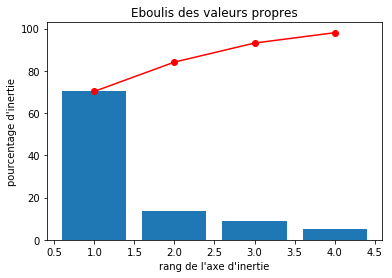

In [15]:
n_comp = 4   # choix du nbre de composantes à calculer : F1,F2,F3,F4

# Choix des variables à prendre en compte dans l'ACP
data_pca = tot[["kcal","Proteine","ani%","popPlus%","PIB"]]   # Choix_A
# data_pca = tot[["kcal","Proteine","ani%","popPlus%","PIB","tdi"]]   # Choix_B
# data_pca = tot[["kcal","Proteine","popPlus%","PIB","tdi"]]   # Choix_C
# data_pca = tot[["kcal","Proteine","ani%","popPlus%"]]   # Choix_D


continents = tot[["continent"]]   # Le continent associé au pays
# préparation des données pour l'ACP
# data_pca = data_pca.fillna(data_pca.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
X = data_pca.values                         # conversion en numpy.ndarray => suppression du nom de colonne et ligne

pays = tot["Pays"]
features = data_pca.columns
# features = tot.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des 'n_comp' premières composantes principales
pca = decomposition.PCA(n_components=n_comp)   # pca de type 'sklearn.decomposition.pca.PCA'
pca.fit(X_scaled)                              # X_scaled de type numpy.ndarray

print(pca.explained_variance_ratio_)        # Pourcentage de variance expliquée par chacune des composantes
print(pca.explained_variance_ratio_.sum())  # Variance expliquée cumulée = 1

# La 1ère composante explique 67.57% de la variance observée, la 2nd explique 16.02% -> Choix_A
# La 1ère composante explique 56.68% de la variance observée, la 2nd explique 17.23% -> Choix_B
# La 1ère composante explique 54.95% de la variance observée, la 2nd explique 20.28% -> Choix_C
# La 1ère composante explique 69.80% de la variance observée, la 2nd explique 17.41% -> Choix_D
# La 1ère composante explique 70.24% de la variance observée, la 2nd explique 13.86% -> Choix_D - Oman

# --- Eboulis des valeurs propres :  - Pourcentage d’inertie totale associé à chaque axe (en bleu)
#                                    - Somme cumulée des inerties                        (en rouge)
display_scree_plot(pca)

## Projection des variables :  Cercle des corrélations

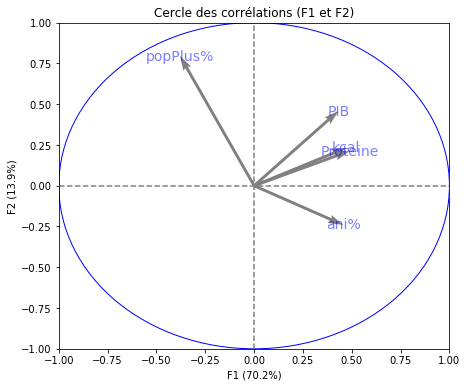

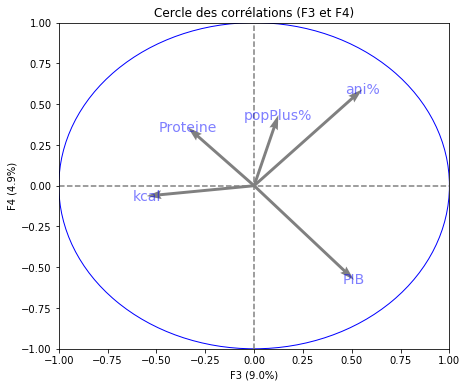

In [16]:
import scipy.stats as st

pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3)], labels = np.array(features))

# Le 1er plan factoriel (F1+F2) représente (70.2 + 13.9)% = 82.4% de l'inertie totale => 82.4% de la variance
#    => on peut se contenter de ce 1er plan
# (PIB,Proteine,kcal,ani%) sont les variables initiales les plus corrélées à F1
# popPlus% est corrélé à F2
# PIB est autant corrélé à F1 que F2

# Rappel :  les composantes principales synthétisent les variables initiales 

In [17]:
# F1 = pca.components_[0]; print("F1 =",F1)
# F2 = pca.components_[1]; print("F2 =",F2)

# F1  est une combinaison linéaire des variables kcal , Proteine , ani% , popPlus% , PIB
# F1 = [  0.47244909*kcal   0.48868206*Proteine  0.45549012*ani% -0.37970036*popPlus%  0.43166896*PIB ]
# F2 = [  0.23230852*kcal   0.21275009*Proteine  -0.24015096*ani% 0.79570308*popPlus%  0.45820768*PIB ]

### Projection des Pays par continent

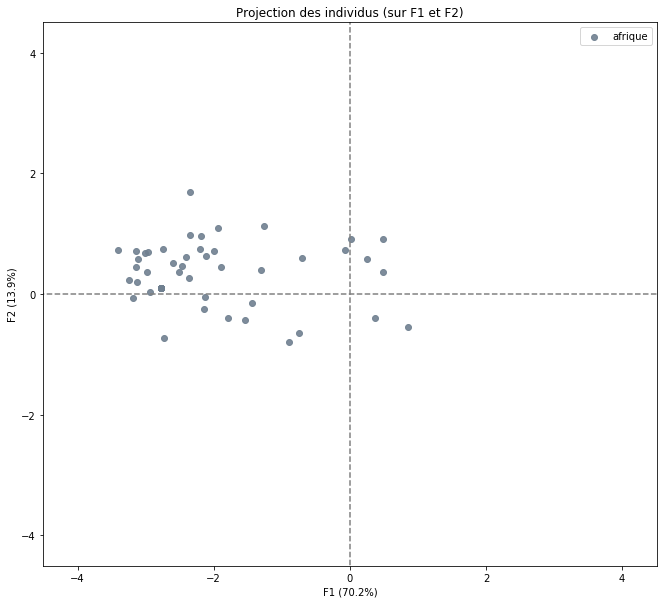

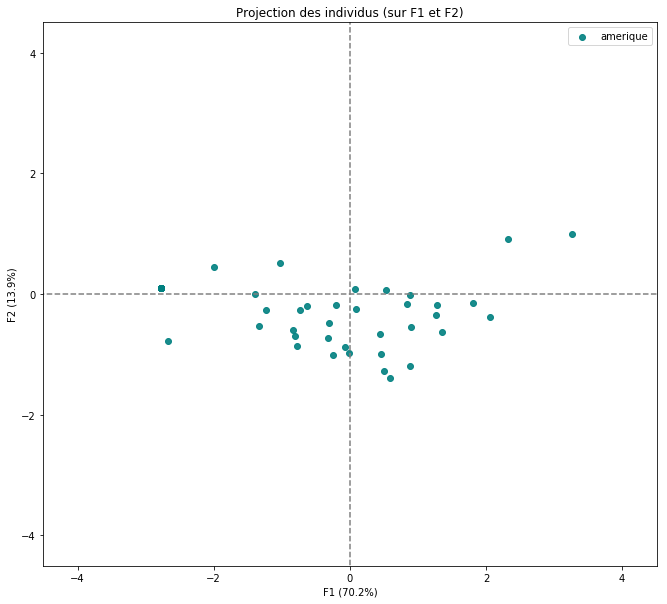

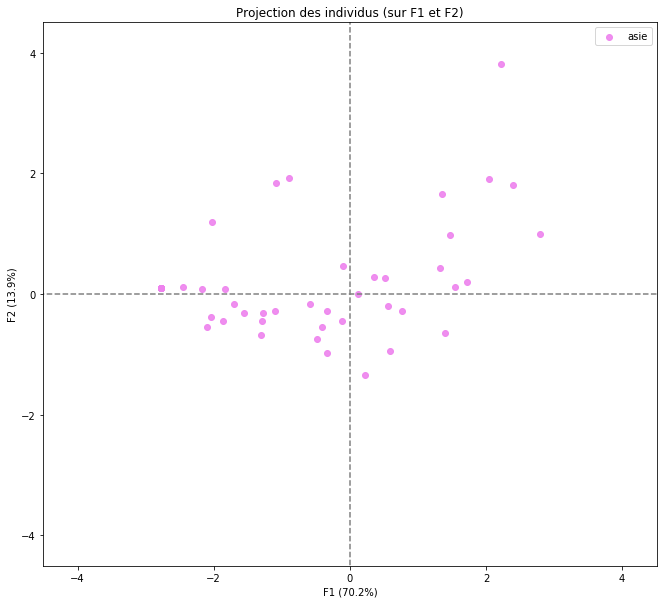

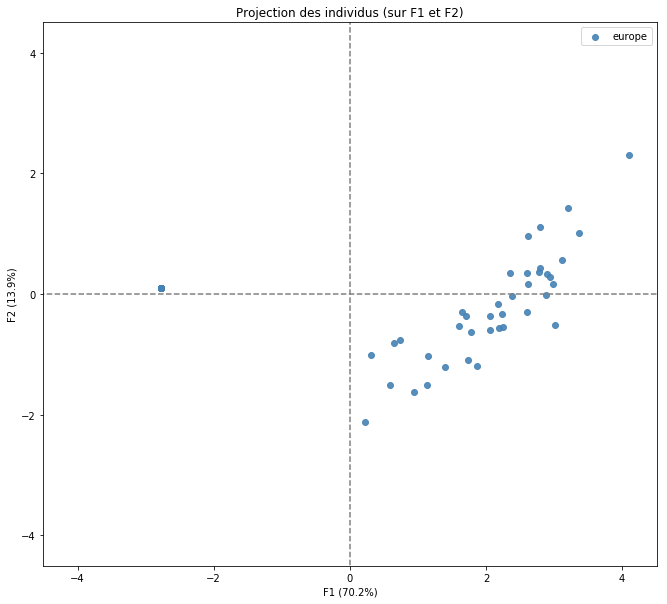

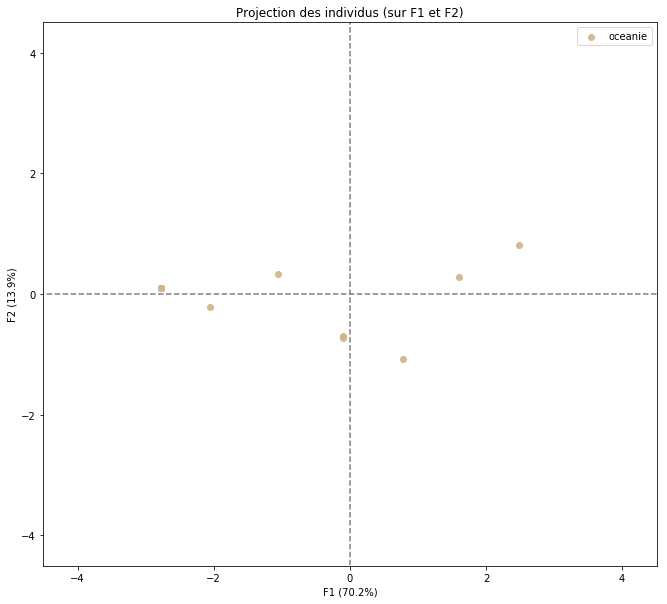

In [18]:
# Projection des Pays par continent

X_projected = pca.transform(X_scaled)

# Colore selon le continent du pays
display_factorial_planes(X_projected,n_comp,pca,[(0,1)], illustrative_var=continents, alpha=0.9, continent="afrique")
display_factorial_planes(X_projected,n_comp,pca,[(0,1)], illustrative_var=continents, alpha=0.9, continent="amerique")
display_factorial_planes(X_projected,n_comp,pca,[(0,1)], illustrative_var=continents, alpha=0.9, continent="asie")
display_factorial_planes(X_projected,n_comp,pca,[(0,1)], illustrative_var=continents, alpha=0.9, continent="europe")
display_factorial_planes(X_projected,n_comp,pca,[(0,1)], illustrative_var=continents, alpha=0.9, continent="oceanie")

plt.show()

### Projection de tous les PAYS    (Une couleur -> Un continent)

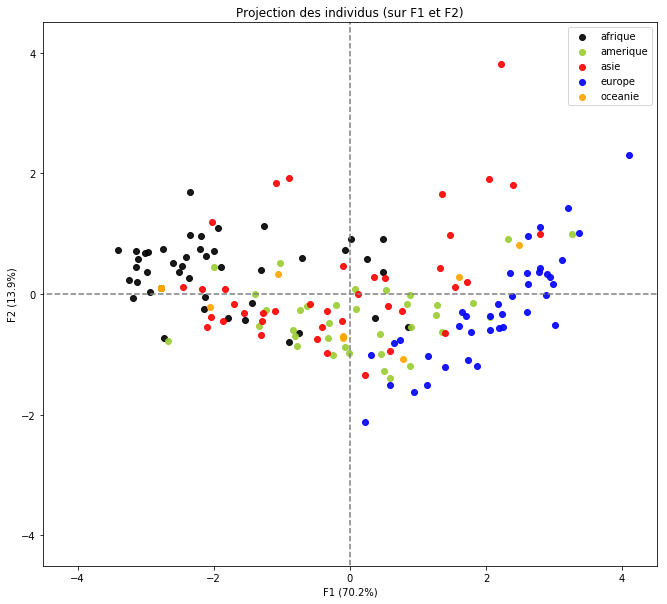

In [19]:
# Projection de tous les Pays sur le 1er plan factoriel (F1,F2)
X_projected = pca.transform(X_scaled)

display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var = continents, alpha = 0.9)

plt.show()

## Classification hiérarchique

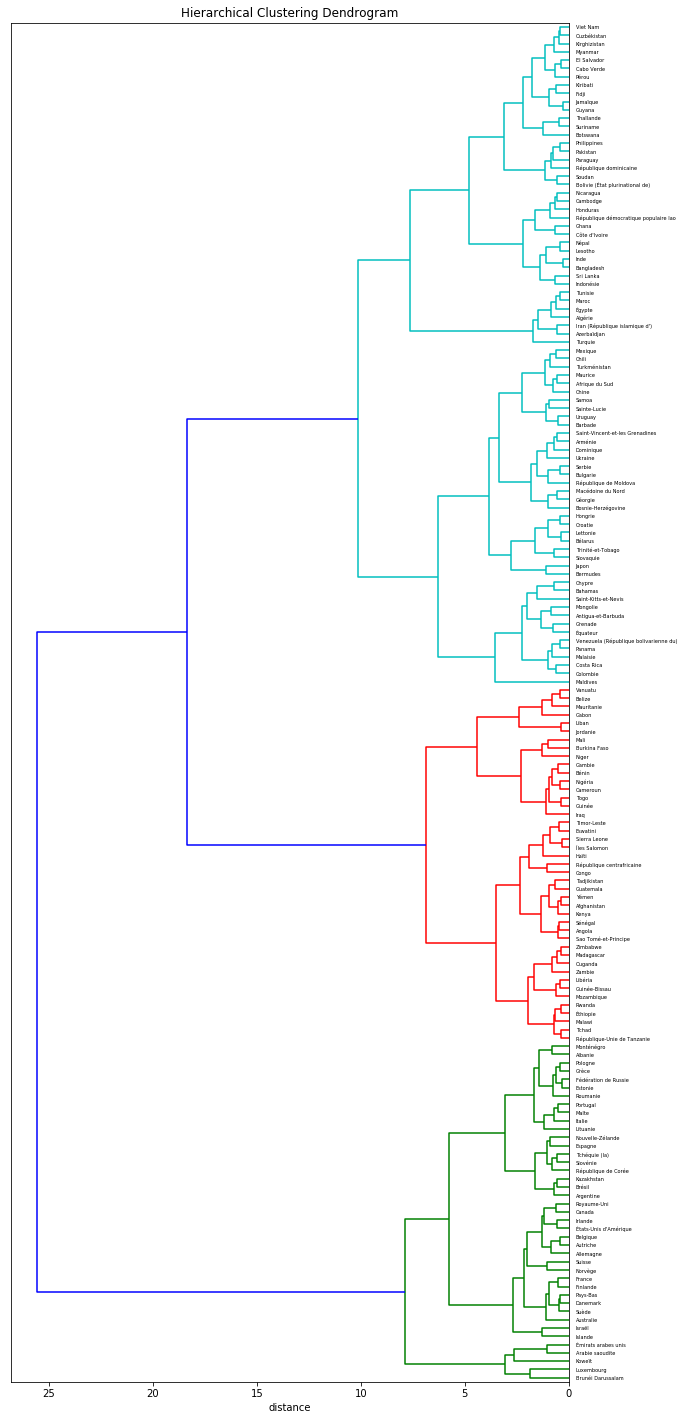

pandas.core.series.Series

In [20]:
import pandas as pd
from functions import plot_dendrogram
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn import preprocessing

data = tot[["kcal","Proteine","ani%","popPlus%","PIB"]]   # Choix_A
# data = tot[["kcal","Proteine","ani%","popPlus%","PIB","tdi"]]   # Choix_B
# data = tot[["kcal","Proteine","popPlus%","PIB","tdi"]]   # Choix_C
# data = tot[["kcal","Proteine","ani%","popPlus%"]]   # Choix_D


# préparation des données pour le clustering
X = data.values
Pays = tot["Pays"]
continents = tot[["continent"]]

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique avec la méthode de Ward pour diminuer l'inertie intraclasse
Z = linkage(X_scaled, 'ward')

# Affichage du dendrogramme
plot_dendrogram(Z, Pays.unique())
type(Pays.unique())   # numpy.ndarray
type(Pays)   # pandas.core.series.Series

### Decoupage du Dendrogramme

In [21]:
x = 5   # Decoupage du dendrogramme en 'x' clusters

clusters = fcluster(Z, x, criterion='maxclust')   # (Option : criterion='distance')

# clusters   # Affiche le numéro de cluster attribué à chaque pays

In [22]:
# Affichage du nombre de Pays, par Cluster et Continent
continent = continents.continent
cc = pd.DataFrame({"continent": continent, "cluster": clusters, "Pays": Pays})

# Cumul du nbre de pays par (continent & cluster)
print(cc.pivot_table(index="continent", columns="cluster", aggfunc=len, fill_value=0))

cc2 = cc.copy()
cc2 = cc2.drop(['continent'], 1)   # Suppression des colonnes inutiles

totCluster = pd.merge(tot,cc2,on='Pays')   # totCluster est comme 'tot' + la colonne 'cluster'

clus = totCluster[["cluster"]]

          Pays                
cluster      1   2   3   4   5
continent                     
afrique      0   0  31   2  10
amerique     0   4   3  18  10
asie         4   3   7   9  17
europe       1  27   0  11   0
oceanie      0   2   2   1   2


### Projection de tous les PAYS    (Une couleur -> Un cluster)

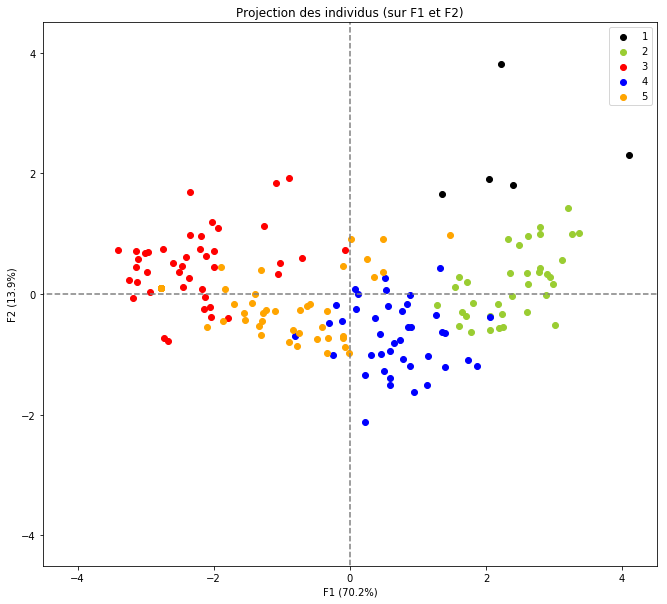

In [23]:
# Projection des individus (= Pays)

# display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3)], labels=None, alpha=1, illustrative_var=clus, continent=None, cluster=None)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], labels=None, alpha=1, illustrative_var=clus, continent=None, cluster=None)

plt.show()

In [24]:
# cluster 1 :   5 pays dont 4 d'asie
# cluster 2 :  36 pays dont 27 d'europe
# cluster 3 :  43 pays dont 31 d'afrique
# cluster 4 :  41 pays dont 11 en europe et 18 en amerique et 9 asie
# cluster 5 :  39 pays dont 17 en asie et 10 en afrique et 10 en amerique

In [25]:
totCluster.sort_values(by = ['popPlus%'], ascending = False)

,Pays,kcal,Proteine,ani%,popPlus%,PIB,continent,tdi,cluster
106,Niger,2547,80.94,18.198666,3.928426,874.1,afrique,10.53,3
77,Jordanie,3100,79.59,34.150019,3.780853,8756.7,asie,34.71,3
86,Liban,3066,79.71,36.783340,3.765870,14400.6,asie,17.17,3
82,Koweït,3501,108.24,49.501109,3.661538,74084.5,asie,77.22,1
110,Ouganda,2130,52.68,23.519362,3.392395,1610.8,afrique,0.00,3
161,Zambie,1930,55.22,16.714958,3.296625,3576.7,afrique,4.17,3
54,Gambie,2628,61.55,22.908205,3.238414,1584.8,afrique,80.00,3
5,Angola,2473,57.26,32.134125,3.126651,6188.0,afrique,91.94,3
162,Zimbabwe,2110,48.35,24.322647,3.104051,1929.8,afrique,8.57,3
125,République-Unie de Tanzanie,2208,57.80,17.647059,3.076408,2316.4,afrique,2.20,3


### Sauvegarde des Clusters en fichiers CSV

In [26]:
totCluster[totCluster.cluster == 1].sort_values(by = ['continent'], ascending = True).to_csv("clus1.csv", index = False)
totCluster[totCluster.cluster == 1].sort_values(by = ['continent'], ascending = True)


,Pays,kcal,Proteine,ani%,popPlus%,PIB,continent,tdi,cluster
7,Arabie saoudite,3255,91.63,43.577431,1.912472,49537.6,asie,62.16,1
25,Brunéi Darussalam,2985,93.41,56.685580,1.456311,79070.2,asie,7.69,1
43,Émirats arabes unis,3280,104.62,39.858536,1.520747,61688.4,asie,100.00,1
82,Koweït,3501,108.24,49.501109,3.661538,74084.5,asie,77.22,1
89,Luxembourg,3539,113.88,63.329821,1.145038,90656.4,europe,90.91,1


In [27]:
totCluster[totCluster.cluster == 2].sort_values(by = ['continent'], ascending = True).to_csv("clus2.csv", index = False)
totCluster[totCluster.cluster == 2].sort_values(by = ['continent'], ascending = True)

,Pays,kcal,Proteine,ani%,popPlus%,PIB,continent,tdi,cluster
8,Argentine,3229,102.64,65.218239,0.873756,19482.2,amerique,0.25,2
24,Brésil,3263,94.99,55.363722,0.858771,15432.9,amerique,0.03,2
31,Canada,3494,104.95,52.120057,0.987428,42339.4,amerique,17.52,2
47,États-Unis d'Amérique,3682,109.60,63.667883,0.801877,51003.7,amerique,0.63,2
73,Israël,3610,128.14,56.555330,1.164312,31250.8,asie,0.00,2
121,République de Corée,3334,96.20,47.952183,0.530580,32548.7,asie,16.62,2
78,Kazakhstan,3264,96.41,59.184732,1.044804,22972.4,asie,56.25,2
88,Lituanie,3417,124.49,61.442686,-0.363276,25143.9,europe,40.24,2
95,Malte,3378,110.36,55.944183,0.233645,30050.1,europe,69.23,2
101,Monténégro,3491,112.07,56.313019,0.000000,14551.4,europe,70.00,2


In [28]:
totCluster[totCluster.cluster == 3].sort_values(by = ['continent'], ascending = True).to_csv("clus3.csv", index = False)
totCluster[totCluster.cluster == 3].sort_values(by = ['continent'], ascending = True)

,Pays,kcal,Proteine,ani%,popPlus%,PIB,continent,tdi,cluster
92,Malawi,2367,64.55,12.068164,2.873130,1062.2,afrique,0.00,3
161,Zambie,1930,55.22,16.714958,3.296625,3576.7,afrique,4.17,3
94,Mali,2890,85.20,27.805164,3.016023,1793.7,afrique,6.38,3
98,Mauritanie,2876,84.96,39.865819,2.476291,3565.5,afrique,77.27,3
102,Mozambique,2283,45.70,13.894967,2.503670,1034.6,afrique,27.03,3
106,Niger,2547,80.94,18.198666,3.928426,874.1,afrique,10.53,3
107,Nigéria,2700,63.76,15.448557,2.831776,5479.1,afrique,0.33,3
110,Ouganda,2130,52.68,23.519362,3.392395,1610.8,afrique,0.00,3
90,Madagascar,2052,46.67,21.469895,2.830358,1364.3,afrique,0.00,3
120,République centrafricaine,1879,46.06,37.190621,2.011050,593.1,afrique,14.29,3


In [29]:
totCluster[totCluster.cluster == 4].sort_values(by = ['continent'], ascending = True).to_csv("clus4.csv", index = False)
totCluster[totCluster.cluster == 4].sort_values(by = ['continent'], ascending = True)

,Pays,kcal,Proteine,ani%,popPlus%,PIB,continent,tdi,cluster
1,Afrique du Sud,3022,85.33,42.634478,0.744474,12339.7,afrique,17.97,4
97,Maurice,3065,88.36,45.065641,0.322581,17628.8,afrique,4.08,4
158,Venezuela (République bolivarienne du),2631,73.01,52.212026,1.502253,17665.2,amerique,23.37,4
99,Mexique,3072,87.63,46.399635,1.228827,16385.1,amerique,23.04,4
58,Grenade,2447,69.19,60.109842,0.952381,11262.7,amerique,87.50,4
113,Panama,2733,79.44,52.429507,1.630721,19377.9,amerique,9.43,4
44,Équateur,2344,61.36,59.533898,1.587916,10665.5,amerique,0.29,4
40,Dominique,2931,76.25,51.396721,0.000000,9871.7,amerique,100.00,4
129,Sainte-Lucie,2595,85.71,59.059620,0.552486,12415.7,amerique,92.31,4
36,Costa Rica,2848,75.07,54.589050,1.394381,14035.3,amerique,6.67,4


In [30]:
totCluster[totCluster.cluster == 5].sort_values(by = ['continent'], ascending = True).to_csv("clus5.csv", index = False)
totCluster[totCluster.cluster == 5].sort_values(by = ['continent'], ascending = True)

,Pays,kcal,Proteine,ani%,popPlus%,PIB,continent,tdi,cluster
3,Algérie,3296,91.96,27.174859,1.886596,13253.6,afrique,1.03,5
152,Tunisie,3349,98.59,28.775738,1.121839,10579.1,afrique,0.98,5
96,Maroc,3403,97.93,27.203104,1.497494,6995.9,afrique,0.58,5
23,Botswana,2326,64.86,40.718471,0.848303,15568.3,afrique,54.55,5
28,Cabo Verde,2609,73.65,37.922607,1.012146,5963.9,afrique,90.00,5
83,Lesotho,2529,73.52,17.383025,1.072125,2631.0,afrique,80.95,5
37,Côte d'Ivoire,2799,58.51,23.363528,2.399194,2879.9,afrique,2.04,5
41,Égypte,3522,103.24,25.513367,1.652585,9814.2,afrique,10.56,5
56,Ghana,3016,64.57,26.668732,2.124892,3807.3,afrique,77.23,5
139,Soudan,2336,70.71,41.295432,2.067482,4177.3,afrique,4.17,5


In [31]:
# totCluster[totCluster.tdi].sort_values(by = ['tdi'], ascending = True)
totCluster.sort_values(by = ['cluster'], ascending = True)
totCluster.sort_values(by = ['tdi'], ascending = True)

,Pays,kcal,Proteine,ani%,popPlus%,PIB,continent,tdi,cluster
128,Rwanda,2228,56.81,9.839817,2.784081,1552.8,afrique,0.00,3
79,Kenya,2206,61.84,25.711514,2.723609,2683.0,afrique,0.00,3
48,Éthiopie,2131,60.40,12.731788,2.585878,1325.8,afrique,0.00,3
123,République démocratique populaire lao,2451,68.90,21.175617,1.865784,5115.6,asie,0.00,5
140,Sri Lanka,2539,59.71,27.315358,0.829463,10238.7,asie,0.00,5
90,Madagascar,2052,46.67,21.469895,2.830358,1364.3,afrique,0.00,3
134,Sénégal,2456,58.49,26.072833,2.965176,2196.0,afrique,0.00,3
92,Malawi,2367,64.55,12.068164,2.873130,1062.2,afrique,0.00,3
146,Tchad,2110,62.72,15.465561,3.028599,2007.1,afrique,0.00,3
27,Burkina Faso,2720,79.38,13.945578,2.885784,1562.3,afrique,0.00,3


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


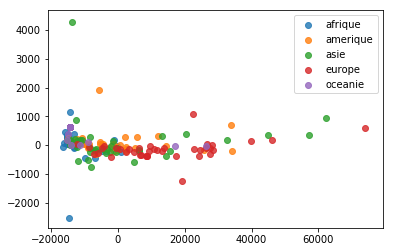

In [32]:
#  t-SNE :  comment sont organisées les données
import numpy as np
import matplotlib.pyplot as plt
from sklearn import (manifold, datasets, decomposition, ensemble,discriminant_analysis, random_projection)
from matplotlib import offsetbox


from sklearn.manifold import TSNE

def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

# --------------------------------------------------------

continents = tot[["continent"]]
pays = tot["Pays"]   
data = tot[["kcal","Proteine","ani%","popPlus%","PIB"]]   # Choix_A
# data = tot[["kcal","Proteine","ani%","popPlus%","PIB","tdi"]]   # Choix_B
# data = tot[["kcal","Proteine","popPlus%","PIB","tdi"]]   # Choix_C
# data = tot[["kcal","Proteine","ani%","popPlus%"]]   # Choix_D
X = data.values

tsne = manifold.TSNE(n_components=2, perplexity=40, n_iter=300, init='pca')
X_2d = tsne.fit_transform(X)

#num_pays = len(pays)
#for i in range(num_pays):
#    plt.scatter(X_embedded[i, 0], X_embedded[i, 1])

  
illustrative_var = np.array(continents)       
for value in np.unique(illustrative_var):
    selected = np.where(illustrative_var == value)
    plt.scatter(X_2d[selected, 0], X_2d[selected, 1], alpha=0.8, label=value)
    plt.legend()
    
#fashion_scatter(X_2d, continents)

###  Classifier selon K-means

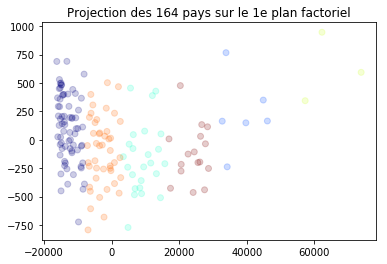

In [33]:
#  Cluster selon K-means

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import decomposition

# Nombre de clusters souhaités
n_clust = 6

data = tot[["kcal","Proteine","ani%","popPlus%","PIB"]]   # Choix_A
# data = tot[["kcal","Proteine","ani%","popPlus%","PIB","tdi"]]   # Choix_B
# data = tot[["kcal","Proteine","popPlus%","PIB","tdi"]]   # Choix_C
# data = tot[["kcal","Proteine","ani%","popPlus%"]]   # Choix_D

# Continent auxquel appartient le pays
continents = tot[["continent"]]

# préparation des données pour le clustering
X = data.values

# Réduire n'est ici pas nécessaire car les variables sont exprimées dans la même unité
X_scaled = preprocessing.StandardScaler().fit_transform(X)

# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X)

# Récupération des clusters attribués à chaque individu
clusters = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=3).fit(X)
X_projected = pca.transform(X)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters.astype(np.float), cmap = 'jet', alpha=.2)
plt.title("Projection des {} pays sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)

# Comparaison des clusters trouvés avec la classification des pays en différents continents
continent = continents.continent
cc = pd.DataFrame({"continent": continent, "cluster": clusters, "pays": pays})


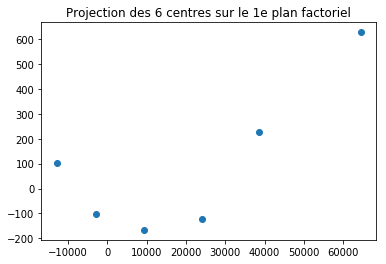

In [34]:
# Affichage des Centroides

plt.figure()
centroids = km.cluster_centers_
centroids_projected = pca.transform(centroids)
plt.scatter(centroids_projected[:,0],centroids_projected[:,1])
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids)))
plt.show()

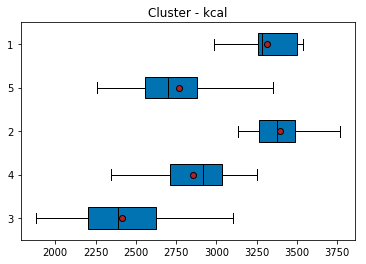

In [35]:
#  kcal / Cluster

X = "cluster" # qualitative
Y = "kcal"   # quantitative

# Changement de la palette graphique
sns.set_palette(sns.color_palette("colorblind", 3))

modalites = totCluster[X].unique()
groupes = []
for m in modalites:
    groupes.append(totCluster[totCluster[X]==m][Y])
    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.title("Cluster - kcal")

plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()


# Rappel : Une boîte à moustaches permet de visualiser rapidement la symétrie de la distribution des données réelles 
#              et la présence de valeurs atypiques.
# Elle représente une distribution empirique à l'aide de quelques paramètres de localisation : la médiane (M), le 1er (Q1) et
#      3ème (Q3) quartile.

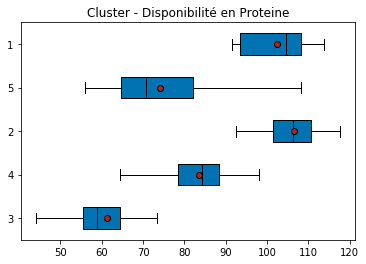

In [36]:
#  Disponibilité alimentaire en protéines / Cluster

X = "cluster" # qualitative
Y = "Proteine"   # quantitative

# Changement de la palette graphique
sns.set_palette(sns.color_palette("colorblind", 3))

modalites = totCluster[X].unique()
groupes = []
for m in modalites:
    groupes.append(totCluster[totCluster[X]==m][Y])
    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.title("Cluster - Disponibilité en Proteine")

plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

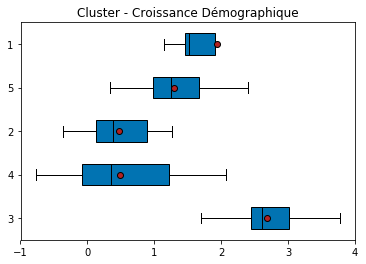

In [37]:
#  Croissance démographique / Cluster

X = "cluster" # qualitative
Y = "popPlus%"   # quantitative

# Changement de la palette graphique
sns.set_palette(sns.color_palette("colorblind", 3))

modalites = totCluster[X].unique()
groupes = []
for m in modalites:
    groupes.append(totCluster[totCluster[X]==m][Y])
    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.title("Cluster - Croissance Démographique")

plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()


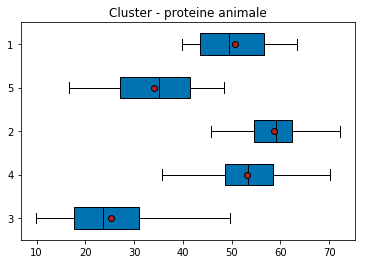

In [38]:
#  %Proteine animale / Cluster

X = "cluster" # qualitative
Y = "ani%"   # quantitative

# Changement de la palette graphique
sns.set_palette(sns.color_palette("colorblind", 3))

modalites = totCluster[X].unique()
groupes = []
for m in modalites:
    groupes.append(totCluster[totCluster[X]==m][Y])
    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.title("Cluster - proteine animale")

plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()


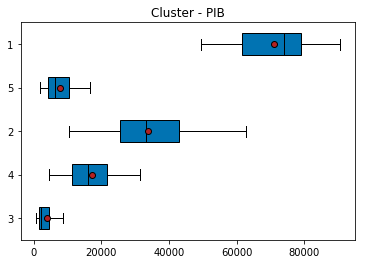

In [39]:
#  PIB / Cluster

X = "cluster" # qualitative
Y = "PIB"     # quantitative

# Changement de la palette graphique
sns.set_palette(sns.color_palette("colorblind", 3))

modalites = totCluster[X].unique()
groupes = []
for m in modalites:
    groupes.append(totCluster[totCluster[X]==m][Y])
    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.title("Cluster - PIB")

plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()


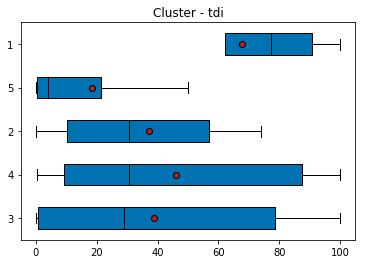

In [40]:
#  tdi / Cluster

X = "cluster" # qualitative
Y = "tdi"     # quantitative

# Changement de la palette graphique
sns.set_palette(sns.color_palette("colorblind", 3))

modalites = totCluster[X].unique()
groupes = []
for m in modalites:
    groupes.append(totCluster[totCluster[X]==m][Y])
    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.title("Cluster - tdi")

plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

# Statistiques descriptives - PIB

In [41]:
import numpy, math


# # On calcule la moyenne empirique :
# xbar = numpy.mean(tot['PIB'])
# print("Moyenne empirique du PIB =",round(xbar,2))         # 17849.82

# # ... la variance “biaisée” :
# v = numpy.var(tot['PIB'])
# print("Variance biaisée du PIB =",round(v,2))             # 371694795.28

# # ... la variance non biaisée :
# sprime2 = numpy.var(tot['PIB'], ddof=1)
# print("Variance non biaisée du PIB =",round(sprime2,2))   # 373933920.56

# # ... l’écart-type :
# sprime = numpy.std(tot['PIB'], ddof=1)
# print("Ecart-type du PIB =",round(sprime,2))              # 19337.37

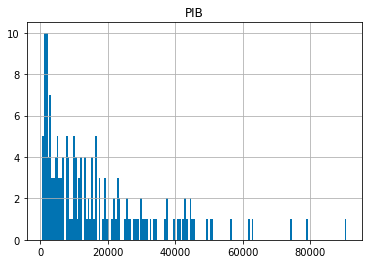

Min = 593.1
Max = 90656.4
Moyenne =  16781.7030487805


In [42]:
# Histogramme du PIB :

import matplotlib.pyplot as plt
%matplotlib inline

PIB_moy = numpy.mean(tot['PIB'])
tot["PIB"].hist(bins=167)
plt.title('PIB')
plt.show()

print("Min =",min(tot['PIB']))    # 593.1
print("Max =",max(tot['PIB']))    # 135319
print("Moyenne = ",PIB_moy) # 17850

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


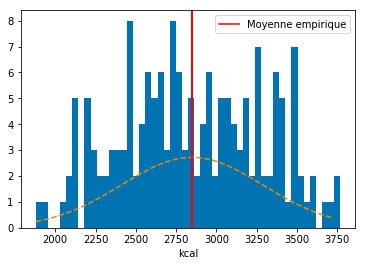

Min = 1879
Max = 3768
Moyenne =  2849.4451219512193
Ecart-type =  439.55118287714413


In [43]:
# Histogramme kcal

import matplotlib.mlab as mlab
import matplotlib.lines as mlines
import matplotlib.pyplot as pyplot
from scipy.stats import norm

fig, ax = plt.subplots()
#n, bins, patches = ax.hist(temp3['kcal'], normed=False, bins=range(1879,3768))
n, bins, patches = ax.hist(tot['kcal'], normed=False, bins=(50))    # affiche l'histogramme 167 -> 50 classes

bins=numpy.arange(1879,3768,50)             # Les abcisses
kcal_std = numpy.std(tot['kcal'], ddof=1)   # écart-type
kcal_moy = numpy.mean(tot['kcal'])          # moyenne


y = mlab.normpdf(bins, kcal_moy, kcal_std)*3000   # calcule chacun des elts de la courbe gausienne
# --> Pour obtenir la probabilité des bins sachant que la moyenne=kcal_moy & l'écart-type=kcal_std

ax.plot(bins, y, '--')       # trace la courbe
ax.set_xlabel('kcal')
#ax.set_title("Histogramme et densité normale")

plt.axvline(kcal_moy, color='r', linewidth=2)
plt.legend(handles=[mlines.Line2D([], [], color='red',markersize=15, label="Moyenne empirique")])  # légende
plt.show()

#len(temp3)   # 167
print("Min =",min(tot['kcal']))         # 1879
print("Max =",max(tot['kcal']))         # 3768
print("Moyenne = ",kcal_moy)    # 2854
print("Ecart-type = ",kcal_std) # 437

# Il faut que la moyenne empirique tombe dans le mode de la distribution, dans le cas d'une loi normale

#  La fonction de densité (en pointillée) permet d'apprécier le rapprochement entre la distribution empirique (histogramme) 
#     et la distribution théorique (la courbe).


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  from ipykernel import kernelapp as app


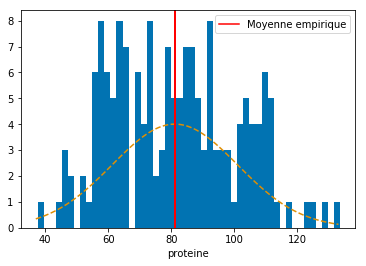

Min = 37.66
Max = 133.54
Moyenne =  81.11262195121952


In [44]:
# Histogramme Proteine

import matplotlib.mlab as mlab
import matplotlib.lines as mlines
import matplotlib.pyplot as pyplot
from scipy.stats import norm

fig, ax = plt.subplots()
n, bins, patches = ax.hist(tot['Proteine'], normed=False, bins=(50))    # affiche l'histogramme 167 -> 50 classes

bins=numpy.arange(37,134,1)                      # Les abcisses
prot_std = numpy.std(tot['Proteine'], ddof=1)   # écart-type
prot_moy = numpy.mean(tot['Proteine'])          # moyenne

y = mlab.normpdf(bins, prot_moy, prot_std)*200   # calcule chacun des elts de la courbe gausienne

ax.plot(bins, y, '--')       # trace la courbe
ax.set_xlabel('proteine')
#ax.set_title("Histogramme et densité normale")

plt.axvline(prot_moy, color='r', linewidth=2)
plt.legend(handles=[mlines.Line2D([], [], color='red',markersize=15, label="Moyenne empirique")])  # légende
plt.show()

print("Min =",min(tot['Proteine']))     # 37.66
print("Max =",max(tot['Proteine']))     # 133.54
print("Moyenne = ",prot_moy)    # 81.52

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  from ipykernel import kernelapp as app


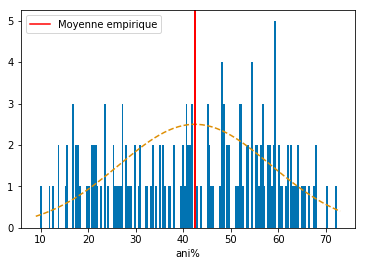

Min = 9.839816933638442
Max = 72.24801557585742
Moyenne =  42.453193240464984


In [45]:
# Histogramme ani%

import matplotlib.mlab as mlab
import matplotlib.lines as mlines
import matplotlib.pyplot as pyplot
from scipy.stats import norm

fig, ax = plt.subplots()
n, bins, patches = ax.hist(tot['ani%'], normed=False, bins=(167))    # affiche l'histogramme 167 -> 50 classes

bins=numpy.arange(9,74,1)                  # Les abcisses
ani_std = numpy.std(tot['ani%'], ddof=1)   # écart-type
ani_moy = numpy.mean(tot['ani%'])          # moyenne

y = mlab.normpdf(bins, ani_moy, ani_std)*100   # calcule chacun des elts de la courbe gausienne

ax.plot(bins, y, '--')       # trace la courbe
ax.set_xlabel('ani%')
#ax.set_title("Histogramme et densité normale")

plt.axvline(ani_moy, color='r', linewidth=2)
plt.legend(handles=[mlines.Line2D([], [], color='red',markersize=15, label="Moyenne empirique")])  # légende
plt.show()

print("Min =",min(tot['ani%']))      # 9.839816933638442
print("Max =",max(tot['ani%']))      # 73.08406874129122
print("Moyenne = ",ani_moy)  # 42.82

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  from ipykernel import kernelapp as app


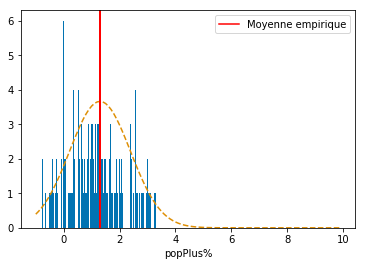

Min = -0.7683551508252703
Max = 3.928425715451419
Moyenne =  1.299232217211115


In [46]:
# Histogramme popPlus%

import matplotlib.mlab as mlab
import matplotlib.lines as mlines
import matplotlib.pyplot as pyplot
from scipy.stats import norm

fig, ax = plt.subplots()
n, bins, patches = ax.hist(tot['popPlus%'], normed=False, bins=(167))    # affiche l'histogramme 167 -> 50 classes

bins=numpy.arange(-1,10,0.1)                         # Les abcisses
popPlus_std = numpy.std(tot['popPlus%'], ddof=1)   # écart-type
popPlus_moy = numpy.mean(tot['popPlus%'])          # moyenne

y = mlab.normpdf(bins, popPlus_moy, popPlus_std)*10   # calcule chacun des elts de la courbe gausienne

ax.plot(bins, y, '--')       # trace la courbe
ax.set_xlabel('popPlus%')
#ax.set_title("Histogramme et densité normale")

plt.axvline(popPlus_moy, color='r', linewidth=2)
plt.legend(handles=[mlines.Line2D([], [], color='red',markersize=15, label="Moyenne empirique")])  # légende
plt.show()


print("Min =",min(tot['popPlus%']))      # -0.7683551508252704
print("Max =",max(tot['popPlus%']))      # 9.595654797827398
print("Moyenne = ",popPlus_moy)  # 1.3477474285564885

## Test de Kolmogorov-Smirnovla :   Teste l'adéquation à une loi normale

In [47]:
from scipy.stats import ks_2samp

# Idée :  étudier l'écart entre la fonction de répartition d'une loi normale et celle estimée de notre échantillon 
#         Plus cette quantité est grande, plus on est enclin à rejeter l'hypothèse comme quoi l'échantillon est gaussien.
#  H0:  F=F0

print("kcal     :  ",ks_2samp(tot["kcal"],list(numpy.random.normal(numpy.mean(tot["kcal"]), numpy.std(tot["kcal"]), 1000))))
print("Proteine :  ",ks_2samp(tot["Proteine"],list(numpy.random.normal(numpy.mean(tot["Proteine"]), numpy.std(tot["Proteine"]), 1000))))
print("ani%     :  ",ks_2samp(tot["ani%"],list(numpy.random.normal(numpy.mean(tot["ani%"]), numpy.std(tot["ani%"]), 1000))))
print("popPlus% :  ",ks_2samp(tot["popPlus%"],list(numpy.random.normal(numpy.mean(tot["popPlus%"]), numpy.std(tot["popPlus%"]), 1000))))
print("PIB      :  ",ks_2samp(tot["PIB"],list(numpy.random.normal(numpy.mean(tot["PIB"]), numpy.std(tot["PIB"]), 1000))))

# n.b:  numpy.std(tot["kcal"])  est l'écart-type empirique



# kcal,Proteine,ani%,popPlus% :  On ne peut pas rejeter H0 => Ces 4 variables suivent sans doute une loi normale
# => On ne peut donc pas rejetter l’hypothèse de normalité au niveau de test 5% étant donnée la p-value :
# kcal     :   Ks_2sampResult(statistic=0.07380487804878044, pvalue=0.41292592495386987)
# Proteine :   Ks_2sampResult(statistic=0.0898780487804878, pvalue=0.19516162910985574)
# ani%     :   Ks_2sampResult(statistic=0.09731707317073168, pvalue=0.1307758690027065)
# popPlus% :   Ks_2sampResult(statistic=0.07956097560975606, pvalue=0.3217956701324899)

# PIB :  On peut rejeter H0 : PIB ne suit pas une loi normale
# PIB      :   Ks_2sampResult(statistic=0.17707317073170725, pvalue=0.0002397902490204857)

kcal     :   Ks_2sampResult(statistic=0.05395121951219517, pvalue=0.7960783822159274)
Proteine :   Ks_2sampResult(statistic=0.0938780487804878, pvalue=0.15800241052477007)
ani%     :   Ks_2sampResult(statistic=0.08831707317073167, pvalue=0.21138319848805426)
popPlus% :   Ks_2sampResult(statistic=0.07870731707317069, pvalue=0.3343864972481327)
PIB      :   Ks_2sampResult(statistic=0.165, pvalue=0.0007876108494410271)


## Test de Shapiro-Wilk :   Teste l'adéquation à une loi normale

In [48]:
import scipy

print("             (statistique       , p-value         )")
print("kcal     :  ",scipy.stats.shapiro(tot["kcal"]))
print("Proteine :  ",scipy.stats.shapiro(tot["Proteine"]))
print("ani%     :  ",scipy.stats.shapiro(tot["ani%"]))
print("popPlus% :  ",scipy.stats.shapiro(tot["popPlus%"]))
print("PIB      :  ",scipy.stats.shapiro(tot["PIB"]))


# kcal,Proteine, :  On peut rejeter H0 => Ces 2 variables ne suivent pas une loi normale
# ani%,popPlus%,PIB :  On ne peut pas rejeter H0 : Ces 3 variables suivent une loi normale

# RESUME des 2 tests :
# . kcal,Proteine,PIB  diffèrent selon le test
# . ani%,popPlus%      ne diffèrent pas avec le test et suivent sans doute une loi normale

#  N.B:  Le test de Shapiro-Wilk est recommandé pour tester la normalité dans le cas de petits échantillons.

             (statistique       , p-value         )
kcal     :   (0.9820395708084106, 0.03191463276743889)
Proteine :   (0.9809772968292236, 0.023614250123500824)
ani%     :   (0.9569465517997742, 6.037151615601033e-05)
popPlus% :   (0.9774144887924194, 0.00876845233142376)
PIB      :   (0.8249365091323853, 9.651612191755032e-13)


## Comparez deux échantillons gaussiens (test de comparaison)

In [ ]:
#                        --- kcal ---

#  1. Test d’égalité des variances avec l'hypothèse nulle :   H0: σ1**2 = σ2**2

clusta = 3
clustb = 5

#  Statistique de test = statistiques de Fisher qui donne  ratio &  p-valeur
print("Egalité-variances/kcal :",scipy.stats.bartlett(totCluster[totCluster.cluster == clusta]['kcal'], \
                                                      totCluster[totCluster.cluster == clustb]['kcal']))
# Ex:  ratio=9.26 et p-valeur=0.23%  => on rejette l’égalité des variances au niveau de test 5%.

# ------------------------------------------------------------------------------

#  2. Test d'égalité des moyennes avec l'hypothèse nulle :   H0: μ1 = μ2

# On teste ensuite l’égalité des moyennes à l’aide de la commande :
print("Egalité-moyennees/kcal :",scipy.stats.ttest_ind(totCluster[totCluster.cluster == clusta]['kcal'], \
                                                       totCluster[totCluster.cluster == clustb]['kcal'], equal_var=True))
# Ex:  p-valeur=7.938489438861141e-28. on rejette facilement l’égalité des moyennes au niveau de test de 5%.


In [ ]:
#                        --- Proteine ---

#  1. Test d’égalité des variances avec l'hypothèse nulle :   H0: σ1**2 = σ2**2

#  Statistique de test = statistiques de Fisher qui donne  ratio &  p-valeur
print("Egalité-variances/Proteine :",scipy.stats.bartlett(totCluster[totCluster.cluster == clusta]['Proteine'], \
                                                          totCluster[totCluster.cluster == clustb]['Proteine']))

# ------------------------------------------------------------------------------

#  2. Test d'égalité des moyennes avec l'hypothèse nulle :   H0: μ1 = μ2

# On teste ensuite l’égalité des moyennes à l’aide de la commande :
print("Egalité-moyennees/Proteine :",scipy.stats.ttest_ind(totCluster[totCluster.cluster == clusta]['Proteine'], \
                                                           totCluster[totCluster.cluster == clustb]['Proteine'], equal_var=True))

In [ ]:
#                        --- ani% ---

#  1. Test d’égalité des variances avec l'hypothèse nulle :   H0: σ1**2 = σ2**2

#  Statistique de test = statistiques de Fisher qui donne  ratio &  p-valeur
print("Egalité-variances/ani% :",scipy.stats.bartlett(totCluster[totCluster.cluster == clusta]['ani%'], \
                                                      totCluster[totCluster.cluster == clustb]['ani%']))

# ------------------------------------------------------------------------------

#  2. Test d'égalité des moyennes avec l'hypothèse nulle :   H0: μ1 = μ2

# On teste ensuite l’égalité des moyennes à l’aide de la commande :
print("Egalité-moyennees/ani% :",scipy.stats.ttest_ind(totCluster[totCluster.cluster == clusta]['ani%'], \
                                                       totCluster[totCluster.cluster == clustb]['ani%'], equal_var=True))

In [ ]:
#                        --- popPLus% ---

#  1. Test d’égalité des variances avec l'hypothèse nulle :   H0: σ1**2 = σ2**2

#  Statistique de test = statistiques de Fisher qui donne  ratio &  p-valeur
print("Egalité-variances/popPlus% :",scipy.stats.bartlett(totCluster[totCluster.cluster == clusta]['popPlus%'], \
                                                          totCluster[totCluster.cluster == clustb]['popPlus%']))

# ------------------------------------------------------------------------------

#  2. Test d'égalité des moyennes avec l'hypothèse nulle :   H0: μ1 = μ2

# On teste ensuite l’égalité des moyennes à l’aide de la commande :
print("Egalité-moyennees/popPlus% :",scipy.stats.ttest_ind(totCluster[totCluster.cluster == clusta]['popPlus%'], \
                                                           totCluster[totCluster.cluster == clustb]['popPlus%'], equal_var=True))

In [ ]:
#                        --- PIB ---

#  1. Test d’égalité des variances avec l'hypothèse nulle :   H0: σ1**2 = σ2**2

#  Statistique de test = statistiques de Fisher qui donne  ratio &  p-valeur
print("Egalité-variances/PIB :",scipy.stats.bartlett(totCluster[totCluster.cluster == clusta]['PIB'], \
                                                     totCluster[totCluster.cluster == clustb]['PIB']))
# Ratio= 58.8 et La p-valeur valant 1.7410557588656552e-14, on rejette l’égalité des variances au niveau de test 5%.

# ------------------------------------------------------------------------------

#  2. Test d'égalité des moyennes avec l'hypothèse nulle :   H0: μ1 = μ2

# On teste ensuite l’égalité des moyennes à l’aide de la commande :
print("Egalité-moyennees/PIB :",scipy.stats.ttest_ind(totCluster[totCluster.cluster == clusta]['PIB'], \
                                                      totCluster[totCluster.cluster == clustb]['PIB'], equal_var=True))

In [ ]:
clusta = 1
clustb = 2
Egalité-variances/kcal : BartlettResult(statistic=0.787645877072407, pvalue=0.37481291110647497)           non rejet
Egalité-moyennees/kcal : Ttest_indResult(statistic=-1.0021914565643575, pvalue=0.32242900824326304)        nrejet
Egalité-variances/Proteine : BartlettResult(statistic=0.00017800130799200818, pvalue=0.9893551689162384)    non rejet
Egalité-moyennees/Proteine : Ttest_indResult(statistic=-0.9023035724923325, pvalue=0.37243480502197546)     non rejet
Egalité-variances/ani% : BartlettResult(statistic=2.292290907368149, pvalue=0.13001789025620875)           non rejet
Egalité-moyennees/ani% : Ttest_indResult(statistic=-2.726174214500945, pvalue=0.009548193081772901)        rejet
Egalité-variances/popPlus% : BartlettResult(statistic=5.432186708816204, pvalue=0.0197689100424962)         rejet
Egalité-moyennees/popPlus% : Ttest_indResult(statistic=5.585980021547636, pvalue=1.9458551328019858e-06)    rejet
Egalité-variances/PIB : BartlettResult(statistic=0.6134834829072058, pvalue=0.433479223944495)             non rejet
Egalité-moyennees/PIB : Ttest_indResult(statistic=6.26483558395707, pvalue=2.220675542327911e-07)          rejet
# -------------------------------------------------------------------------------------------------------

clusta = 1
clustb = 3
Egalité-variances/kcal : BartlettResult(statistic=0.5218764041728547, pvalue=0.47004235714519393)          non rejet
Egalité-moyennees/kcal : Ttest_indResult(statistic=6.446142480968281, pvalue=6.190761856261758e-08)        rejet
Egalité-variances/Proteine : BartlettResult(statistic=0.2575195523660778, pvalue=0.6118293995838653)        non rejet
Egalité-moyennees/Proteine : Ttest_indResult(statistic=7.463728211598655, pvalue=1.8453197876493128e-09)    rejet
Egalité-variances/ani% : BartlettResult(statistic=0.0005441715722458499, pvalue=0.9813890475460944)        non rejet
Egalité-moyennees/ani% : Ttest_indResult(statistic=5.68015449975716, pvalue=8.709923358349734e-07)         rejet
Egalité-variances/popPlus% : BartlettResult(statistic=3.5538641274769702, pvalue=0.05940695422033394)       non rejet
Egalité-moyennees/popPlus% : Ttest_indResult(statistic=-2.6462206216065822, pvalue=0.01110488139453047)     rejet
Egalité-variances/PIB : BartlettResult(statistic=25.999787734987972, pvalue=3.414548980069155e-07)         rejet
Egalité-moyennees/PIB : Ttest_indResult(statistic=23.758731605015914, pvalue=1.809293059849238e-27)        rejet
# -------------------------------------------------------------------------------------------------------
    
clusta = 1
clustb = 4
Egalité-variances/kcal : BartlettResult(statistic=0.00027493846596197394, pvalue=0.9867706680553233)          non rejet
Egalité-moyennees/kcal : Ttest_indResult(statistic=4.3779102630158295, pvalue=7.530541714318768e-05)          rejet
Egalité-variances/Proteine : BartlettResult(statistic=0.013886825148621806, pvalue=0.9061925537146793)      non rejet
Egalité-moyennees/Proteine : Ttest_indResult(statistic=4.026655155168835, pvalue=0.0002257792263718241)     rejet
Egalité-variances/ani% : BartlettResult(statistic=0.16279792369124715, pvalue=0.6865934921669313)             non rejet
Egalité-moyennees/ani% : Ttest_indResult(statistic=-0.7493355751805566, pvalue=0.4577349663716155)            non rejet
Egalité-variances/popPlus% : BartlettResult(statistic=0.41429383828286304, pvalue=0.5197981289442262)       non rejet
Egalité-moyennees/popPlus% : Ttest_indResult(statistic=3.751052422576467, pvalue=0.0005220255461223969)     rejet
Egalité-variances/PIB : BartlettResult(statistic=2.7780162758912925, pvalue=0.09556647063390704)              non rejet
Egalité-moyennees/PIB : Ttest_indResult(statistic=11.367422640969648, pvalue=1.5338000526738763e-14)          rejet
# -------------------------------------------------------------------------------------------------------

clusta = 1
clustb = 5
Egalité-variances/kcal : BartlettResult(statistic=0.9371251837573263, pvalue=0.33301826909228294)          non rejet
Egalité-moyennees/kcal : Ttest_indResult(statistic=3.491196069872783, pvalue=0.0011446659033506532)        rejet
Egalité-variances/Proteine : BartlettResult(statistic=0.6332164887392796, pvalue=0.42617793359652856)       non rejet
Egalité-moyennees/Proteine : Ttest_indResult(statistic=4.539559900034676, pvalue=4.6755056955066e-05)       rejet
Egalité-variances/ani% : BartlettResult(statistic=0.0025262532483166953, pvalue=0.9599137271275757)        non rejet
Egalité-moyennees/ani% : Ttest_indResult(statistic=3.685180526004164, pvalue=0.0006486489782292586)        rejet
Egalité-variances/popPlus% : BartlettResult(statistic=5.232763397494131, pvalue=0.022165290034911567)       rejet
Egalité-moyennees/popPlus% : Ttest_indResult(statistic=2.426283389330421, pvalue=0.01962753715288419)       rejet
Egalité-variances/PIB : BartlettResult(statistic=16.606542631704457, pvalue=4.5992089392941105e-05)        rejet
Egalité-moyennees/PIB : Ttest_indResult(statistic=19.76272515160166, pvalue=6.918373369818973e-23)         rejet
# -------------------------------------------------------------------------------------------------------


clusta = 2
clustb = 3  
Egalité-variances/kcal : BartlettResult(statistic=13.157049827982684, pvalue=0.00028643951101251923)      rejet
Egalité-moyennees/kcal : Ttest_indResult(statistic=17.504253496071815, pvalue=1.4585812500763392e-28)     rejet
Egalité-variances/Proteine : BartlettResult(statistic=1.6601544527443461, pvalue=0.19758247125177655)      non rejet
Egalité-moyennees/Proteine : Ttest_indResult(statistic=18.4316252122776, pvalue=5.8358085434901374e-30)    rejet
Egalité-variances/ani% : BartlettResult(statistic=8.988138641603154, pvalue=0.002717376507407222)         rejet
Egalité-moyennees/ani% : Ttest_indResult(statistic=18.586741772968054, pvalue=3.4405863377613905e-30)     rejet
Egalité-variances/popPlus% : BartlettResult(statistic=0.6806700095349058, pvalue=0.4093561042138232)        non rejet
Egalité-moyennees/popPlus% : Ttest_indResult(statistic=-19.154131666161835, pvalue=5.100920039077271e-31)   rejet
Egalité-variances/PIB : BartlettResult(statistic=42.20764260087978, pvalue=8.207862902052122e-11)         rejet
Egalité-moyennees/PIB : Ttest_indResult(statistic=15.500406299496447, pvalue=2.1936763893686066e-25)      rejet
# -------------------------------------------------------------------------------------------------------

clusta = 2
clustb = 4
Egalité-variances/kcal : BartlettResult(statistic=3.7049007204597766, pvalue=0.0542528989322258)          non rejet
Egalité-moyennees/kcal : Ttest_indResult(statistic=12.051896544661654, pvalue=3.975060402687523e-19)      rejet
Egalité-variances/Proteine : BartlettResult(statistic=0.09557588838548832, pvalue=0.7572047617233855)      non rejet
Egalité-moyennees/Proteine : Ttest_indResult(statistic=10.301932947573743, pvalue=6.04974909332451e-16)    rejet
Egalité-variances/ani% : BartlettResult(statistic=4.679808715654633, pvalue=0.030519146601517347)         rejet
Egalité-moyennees/ani% : Ttest_indResult(statistic=3.116053887159174, pvalue=0.002608734233568294)        rejet
Egalité-variances/popPlus% : BartlettResult(statistic=9.113573819738312, pvalue=0.0025371969000767412)      rejet
Egalité-moyennees/popPlus% : Ttest_indResult(statistic=-0.13671490462350763, pvalue=0.8916274197999516)     non rejet
Egalité-variances/PIB : BartlettResult(statistic=2.6949464059974533, pvalue=0.10066687394321888)          non rejet
Egalité-moyennees/PIB : Ttest_indResult(statistic=6.775758335644473, pvalue=2.566569240269599e-09)        rejet
# -------------------------------------------------------------------------------------------------------

clusta = 2
clustb = 5
Egalité-variances/kcal : BartlettResult(statistic=17.596492283766445, pvalue=2.7309160332325117e-05)      rejet
Egalité-moyennees/kcal : Ttest_indResult(statistic=10.092267456434808, pvalue=1.720761058440397e-15)      rejet
Egalité-variances/Proteine : BartlettResult(statistic=4.086164863273822, pvalue=0.04323563970760318)       rejet
Egalité-moyennees/Proteine : Ttest_indResult(statistic=11.948762359649717, pvalue=7.515356128773157e-19)   rejet
Egalité-variances/ani% : BartlettResult(statistic=8.367455806152048, pvalue=0.003820000431558726)         rejet
Egalité-moyennees/ani% : Ttest_indResult(statistic=13.5456678610955, pvalue=1.3175353657374063e-21)       rejet
Egalité-variances/popPlus% : BartlettResult(statistic=0.011746513111507772, pvalue=0.913693208858471)      non rejet
Egalité-moyennees/popPlus% : Ttest_indResult(statistic=-7.536922445018151, pvalue=1.0404270430889399e-10)  rejet
Egalité-variances/PIB : BartlettResult(statistic=26.570112106229022, pvalue=2.541451434992902e-07)        rejet
Egalité-moyennees/PIB : Ttest_indResult(statistic=12.521527358711287, pvalue=7.446176417027026e-20)       rejet
# -------------------------------------------------------------------------------------------------------
  
clusta = 3
clustb = 4
Egalité-variances/kcal : BartlettResult(statistic=3.3769765050597536, pvalue=0.0661132344542289)            rejet
Egalité-moyennees/kcal : Ttest_indResult(statistic=-7.5620300356969326, pvalue=5.1157034212492846e-11)      rejet
Egalité-variances/Proteine : BartlettResult(statistic=0.869018657951629, pvalue=0.35122712890424646)       non rejet
Egalité-moyennees/Proteine : Ttest_indResult(statistic=-9.228173329563386, pvalue=2.531278759975342e-14)   rejet
Egalité-variances/ani% : BartlettResult(statistic=0.6050578193461977, pvalue=0.4366547200198555)            non rejet
Egalité-moyennees/ani% : Ttest_indResult(statistic=-14.370743232690703, pvalue=4.107231065585262e-24)       rejet
Egalité-variances/popPlus% : BartlettResult(statistic=5.394489899366353, pvalue=0.020200429179444538)      rejet
Egalité-moyennees/popPlus% : Ttest_indResult(statistic=14.974092981025045, pvalue=3.534335146887588e-25)   rejet
Egalité-variances/PIB : BartlettResult(statistic=26.09098590397601, pvalue=3.257010165887123e-07)           rejet
Egalité-moyennees/PIB : Ttest_indResult(statistic=-8.918896220636144, pvalue=1.0435494898246162e-13)        rejet
# -------------------------------------------------------------------------------------------------------
        
clusta = 3
clustb = 5
Egalité-variances/kcal : BartlettResult(statistic=0.5347500018838603, pvalue=0.4646166773456474)          non rejet
Egalité-moyennees/kcal : Ttest_indResult(statistic=-5.002629679519307, pvalue=3.285509059079484e-06)      rejet
Egalité-variances/Proteine : BartlettResult(statistic=0.6664006420338133, pvalue=0.41430932868805803)      non rejet
Egalité-moyennees/Proteine : Ttest_indResult(statistic=-4.558335172439881, pvalue=1.8295822815468934e-05)  rejet
Egalité-variances/ani% : BartlettResult(statistic=0.00424964341093082, pvalue=0.94802328906466)           non rejet
Egalité-moyennees/ani% : Ttest_indResult(statistic=-4.3186521706943894, pvalue=4.466401820748408e-05)     rejet
Egalité-variances/popPlus% : BartlettResult(statistic=0.536670148562912, pvalue=0.4638160104866097)        non rejet
Egalité-moyennees/popPlus% : Ttest_indResult(statistic=12.155664247885113, pvalue=7.322566864553035e-20)   rejet
Egalité-variances/PIB : BartlettResult(statistic=1.893520808941573, pvalue=0.1688053432478302)            non rejet
Egalité-moyennees/PIB : Ttest_indResult(statistic=-4.094197425495345, pvalue=0.00010060690561043993)      rejet
# -------------------------------------------------------------------------------------------------------
   
    
    
# -------------------------------------------------------------------------------------------------------
On veut des clusters qui présentent la même variance (non rejet) et une moyenne différente (rejet) :
    
. clusters (1,2) pour kcal          , ani%,         , PIB   ***
. clusters (1,3) pour kcal, Proteine, ani%, popPlus%        ****
. clusters (1,4) pour kcal, Proteine,     , popPlus%, PIB   ****
. clusters (1,5) pour kcal, Proteine, ani%                  ***
. clusters (2,3) pour     , Proteine,     , popPlus%        **
. clusters (2,4) pour kcal, Proteine,               , PIB   ***
. clusters (2,5) pour                     , popPlus%        *
. clusters (3,4) pour     , Proteine, ani%                  **
. clusters (3,5) pour kcal, Proteine, ani%, popPlus%, PIB   *****



In [ ]:
Chevauchement des clusters
Définition des clusters



